In [1]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Inputs
CATEGORIES_PATH = '/scratch/WikipediaImagesTaxonomy/commonswiki-20220220-category-network.parquet'

In [3]:
def build_category_graph(categories):
        '''
        Build the category graph, starting from the DataFrame extracted by processing dumps
        '''
        categories = categories.set_index('title')
        # Build DiGraph from adjacency matrix
        G = nx.DiGraph(categories.parents.to_dict())
        nx.set_node_attributes(G, dict(zip(categories.index, categories[['id', 'hiddencat']].to_dict(orient='records'))))
        depth = {node: len(sps) for node, sps in nx.shortest_path(G, target='CommonsRoot').items()}
        nx.set_node_attributes(G, depth, name='depth')
        return G

In [4]:
categories = pd.read_parquet(CATEGORIES_PATH)
categories.head()

,id,title,parents,hiddencat,childs
0,89434922,"""Azərişıq"" ASC",[Energy in Azerbaijan],False,"[Vugar Ahmadov, Ilham Aliyev attended opening ..."
1,59340547,"""Flores de María""","[Folk festivals in the Philippines, Flores de ...",False,"[Dapit (May, 2017)]"
2,29072664,"'s-Gravenhof, Zutphen",[Streets in Zutphen],False,"[St Walburgis Church (Zutphen), Town hall of Z..."
3,2145396,'s-Heerenberg,"[Montferland, Populated places in Gelderland, ...",False,"[Patrick Beverloo, De heks van 's-Heerenberg, ..."
4,114888133,'s-Hertogenbosch in art,"['s-Hertogenbosch, Cities in the Netherlands i...",False,"[Prints and drawings of 's-Hertogenbosch, Old ..."


In [5]:
G = build_category_graph(categories)

In [6]:
nx.info(G)

/tmp/ipykernel_6211/1064119803.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'DiGraph with 4100496 nodes and 9930927 edges'

In [7]:
hiddencats = [node for node, hiddencat in nx.get_node_attributes(G, 'hiddencat').items() if hiddencat]
print(f'There are {len(hiddencats)} identified hidden categories, corresponding to the ' +
      f'{len(hiddencats) / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 16352 identified hidden categories, corresponding to the 0.40% of all categories


In [8]:
depth = nx.get_node_attributes(G, 'depth')

In [9]:
print(f'There are {len(depth)} nodes connected to CommonsRoot, corresponding to the ' +
      f'{len(depth) / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 3578565 nodes connected to CommonsRoot, corresponding to the 87.27% of all categories


In [10]:
sorted(Counter(depth.values()).items(), key=lambda x: x[0])

[(1, 1),
 (2, 7),
 (3, 118),
 (4, 2329),
 (5, 49610),
 (6, 202450),
 (7, 595676),
 (8, 1003921),
 (9, 930657),
 (10, 518453),
 (11, 190100),
 (12, 38510),
 (13, 10015),
 (14, 6026),
 (15, 6420),
 (16, 6034),
 (17, 3926),
 (18, 5138),
 (19, 4574),
 (20, 1614),
 (21, 551),
 (22, 626),
 (23, 472),
 (24, 685),
 (25, 317),
 (26, 225),
 (27, 87),
 (28, 16),
 (29, 5),
 (30, 2)]

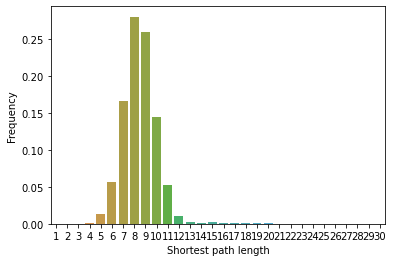

In [11]:
counts = pd.Series(depth).value_counts(sort=False, normalize=True)
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('Shortest path length')
plt.ylabel('Frequency')
plt.show()

In [12]:
not_connected_nodes = set(G.nodes) - set(depth.keys())

In [13]:
# Examples of nodes that cannot reach CommonsRoot
list(not_connected_nodes)[:10]

['',
 'Structures in Chechnya',
 'Aircraft at Cranfield Airport',
 'Actors in 2017',
 'Comedians in 1983',
 'Number 1 on objects',
 'Number 7751 on vehicles',
 '2021 photographs of the United States',
 '2020 in Tərtər Rayon',
 '2011 establishments in Japan']

Almost all those categories in reality are connected, but they have ancestors added via templates (ex. Virginia State Route 7298 or Religious organizations established in 1123). For now, we didn't manage to get the template expansion working, so categories added through templates are not available.

In [14]:
G.out_edges('Virginia State Route 7298')

OutEdgeDataView([])

In [15]:
leaf_it = (x for x in G.nodes() if G.in_degree(x) == 0)
nleaves = sum(1 for _ in leaf_it)

print(f'There are {nleaves} leaf nodes, corresponding to the ' +
      f'{nleaves / G.number_of_nodes() * 100 :.2f}% of all categories')

There are 1908918 leaf nodes, corresponding to the 46.55% of all categories


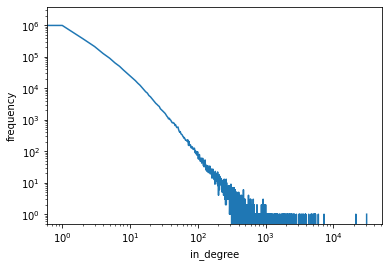

In [16]:
counts = Counter(d for n, d in G.in_degree())
in_degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]

plt.loglog(range(len(in_degree_freq)), in_degree_freq)
plt.xlabel('in_degree')
plt.ylabel('frequency')
plt.show()

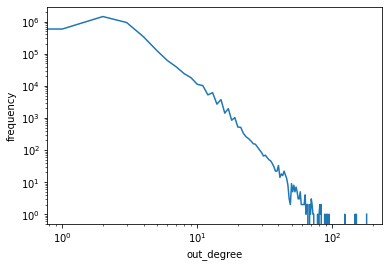

In [17]:
counts = Counter(d for n, d in G.out_degree())
out_degree_freq = [counts.get(i, 0) for i in range(max(counts) + 1)]

plt.loglog(range(len(out_degree_freq)), out_degree_freq)
plt.xlabel('out_degree')
plt.ylabel('frequency')
plt.show()

In [18]:
[(n, depth[n]) for n in G.successors('Chairs')]

[('Seats', 8), ('Single seating furniture', 8)]

In [20]:
descendants_by_depth = [(len(nx.descendants(G, node)), depth[node]) for node in depth.keys()]

In [ ]:
descendants_by_depth[:10]